# RaJoLink workflow notebook tutorial based on Python script modules for LBD

RaJoLink is a method developed for **open** literature-based discovery (LBD). In contrast to Swanson's `ABC` model, RaJoLink focuses on a semi-automatic identification of candidates ($a$) that might be related to an investigated phenomenon ($c$). This selection is based on the identification of **rare terms** from the literature on $c$. At the heart of the RaJoLink strategy is the rational assumption that if literatures on several rare terms have a term in common, this term is a candidate for the term $a$.

The **RaJoLink** method comprises three main steps: **Ra**, **Jo**, and **Link**, which focus on rare terms, joint terms and linking terms, respectively. The Ra step searches the literature on phenomenon $C$ for unique or rare terms. The Jo step reviews articles related to these rare terms, and identifies joint terms (candidates for $a$) that appear in them, suggesting the hypothesis that $C$ is related to $A$. The Link step then looks for $b$-terms that bridge the literature on a selected $a$-term and $c$-term; $b$-terms are the candidates that can possibly explain the link. While Swanson's ABC model connects two disjoint literatures with the term $b$, RaJoLink uses rare terms to find the term $a$, which bridges the literatures with selected rare terms.

This workflow illustrates the experiments with RaJoLink in the autism domain; the entire environment is described in Chapter 7 *Semantic and Outlier-based Open Discovery* of the book *Bisociative Literature-Based Discovery*. The identification of rare terms in the Ra step is based on the statistical principle of outliers. Just as outliers in data can lead to significant discoveries, rare terms in the literature can pave the way for innovative connections. A term is considered rare if it occurs in $n$ or fewer data sets, where $n$ is adjustable depending on the experiment or context.

In this particular implementation, the search for b-terms is limited to the expert-selected [MeSH](https://www.nlm.nih.gov/mesh/meshhome.html) words for Enzymes and Coenzymes [D08] and Amino Acids, Peptides, and Proteins [D12]. The main purpose of MeSH filtering is to reduce the vocabulary size, which in turn improves the time complexity of the LBD algorithms used. Considering only the words from the two MeSH categories also reduces the effort for the human expert in guiding and evaluating the results.

<hr>

[1] Petrič, I., Urbančič, T., Cestnik, B., Macedoni-Lukšič, M. (2009). Literature mining method RaLoLink for uncovering relations between biomedical concepts. Journal of Biomedical Informatics, 42(2), 219–227.

<hr>

Note that **our motive** was to **re-implement parts** of the tools such as **RaJoLink**, OntoGen and CrossBee so that we can generally **repeat the results** with the tools from the past experiments, and not so much to optimize the written Python code. The fucus was on understanding the learning processes and visualizing the workflows in terms of repeatability of the results obtained; the efficiency and elegance of the programming can be addressed in future versions of the scripts.

Import and initialize `logging` library to track the execution of the scripts.

In [1]:
import logging

# Initialize logging with a basic configuration
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s: %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

Import LBD components from the framework notebooks. The description of the individual components from the framework notebooks can be found in the respective notebooks.

The purpose of the **import_ipynb** library is to allow the direct import of Jupyter notebooks as modules so that code, functions and classes defined in one notebook can be easily reused in other notebooks or Python scripts.
If the **import_ipynb** library is omitted (or commented out), the corresponding packages will be imported from **.py** files exported from the **.ipynb** files. Note that importing from **.py** files is usually much faster and therefore more suitable for running scripts in production.

In [2]:
#import import_ipynb
import LBD_01_data_acquisition
import LBD_02_data_preprocessing
import LBD_03_feature_extraction
import LBD_04_text_mining
import LBD_05_results_analysis
import LBD_06_visualization

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bojan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Import additional Python libraries.

In [3]:
import nltk
import numpy as np
import itertools
import pandas as pd
import spacy
from typing import List, Dict

When you run the script for the first time, `en_core_web_md`, a medium sized English model trained on written web text (blogs, news, comments), must be downloaded with the command:

```python
!python -m spacy download en_core_web_md
```

For the first run, you must therefore comment out the first line in the next cell.

In [4]:
#!python -m spacy download en_core_web_md 

nlpr = spacy.load("en_core_web_md")

# Step Ra

Identify a few rare terms in a set of 214 documents about autism.

Define the name of the domain $C$ and load the responding text from the file. The expected file format is as follows:

1. The file is encoded in Ascii (if it is in UTF-8 or other encoding, it should be converted to Ascii).
2. Each line in the file represents one document. The words in each document are separated by spaces. The length of the individual documents may vary.
3. The first word in each line is the **unique id**, followed by a semicolon. Normally **pmid** (pubmed id) can be used for this purpose.
4. The second word in each line can optionally stand for a predefined domain (or class) of the document. In this case, the second word is preceded by **!**. For example, if the file contains documents that originate from two domains, e.g. *migraine* and *magnesium*, the second word in each line is either **!migraine** or **!magnesium**. If the file contains documents that originate from *autism* and *calcineurin*, the second word in each line will be either **!autism** or **!calcineurin**.
5. If the second word is not preceded by **!**, it will be considered the first word of the document. In this case, the document will be given the domain **!NA** (**not applicable** or **not available**).

**A background story for this experiment**

First, we selected *Autism* as our domain of interest. Then we searched PubMed and collected 214 full-text documents on autism from the decade before 2006 in PubMed Central. After collecting the documents, we converted them from HTML and PDF format to plain text and made sure that each document was formatted consistently for further analysis. The 214 full text documents are stored in the file `input/214Texts.txt`.

We extracted around 2000 unique terms, focusing particularly on rare terms from the fields of amino acids, peptides and proteins to assess their potential relevance to autism research. Notable rare terms such as *lactoylglutathione*, *synaptophysin* and *calcium channels* appeared in our dataset.

The selected rare terms *lactoylglutathione*, *synaptophysin* and *calcium channels* prompted our team's autism expert to specifically investigate their associations with *calcineurin* (as it appeared as a joint term in all literatures of the selected rare terms). *Calcineurin* is a protein phosphatase with a high prevalence in the brain.

In [5]:
def truncate_with_ellipsis(string: str, length: int) -> str:
    """
    Truncate a string to a specified length and add ellipsis (...) if it's longer than the length.
    
    Parameters:
    - string (str): the string to be truncated
    - length (int): the maximum allowed length of the truncated string
    
    Returns:
    - str: the truncated string with ellipsis (...) if truncation occurred
    """
    if len(string) > length:
        return string[:length - 3] + '...'  # Adjust for the length of the ellipsis
    return string


In [6]:
domainName = 'Autism'
fileName = 'input/214Texts.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
# display the first 7 lines of the document
[truncate_with_ellipsis(line, 110) for line in lines[:7]]

2024-09-27 12:31:52: INFO - Loaded 214 lines from "input/214Texts.txt".


['16911972: Assessing young children can be difficult, particularly when one considers the type of test behav...',
 '16835068: Autism is a serious neurodevelopmental disorder characterized by impairments in social interactio...',
 '16816240: Increased brain size is one of the most consistent neurobiologic findings in autism,1-2 and appea...',
 '16770606: Autism is a neurodevelopmental disorder characterized by severe impairment in social interaction ...',
 '16722615: Disease name and synonyms X-linked alpha thalassaemia mental retardation (ATR-X) syndrome. Defini...',
 "16709250: Autism and related autism spectrum disorders (including Asperger's Syndrome and pervasive develop...",
 '16703115: Autism is diagnosed on the basis of abnormalities or impaired development in three areas: social ...']

**Load and preprocess prepared MeSH terms**

The next script is part of a pipeline that is used to pre-process medical literature data and focuses on terms related to specific MeSH (Medical Subject Headings) categories. In this specific case, it is about loading and preprocessing MeSH terms for Enzymes and Coenzymes [D08] and Amino Acids, Peptides, and Proteins [D12]. The input file MESH_D08_D12.txt was created by selecting the relevant [D08] and [D12] terms from the xml file `desc2024.xml`, which was downloaded from <a href="https://www.nlm.nih.gov/databases/download/mesh.html">the MeSH website</a>. The input file contains 3534 words after preprocessing, which are used as filters in the further preprocessing of autism-related files.

**Functionality**

1. *Load data*: The script starts loading MeSH data from a specified file. The file `MESH_D08_D12.txt` contains words that refer to certain MeSH categories (D08 and D12).

2. *Dictionary construction*: In the next step, a dictionary is constructed from the loaded lines. This converts the list of lines into a dictionary (`mesh_docs_dict`) in which the keys represent document identifiers and the values contain the corresponding text. This structure is more efficient for subsequent text processing tasks.

3. *Pre-processing of documents*: In the pre-processing phase, the text data is cleaned up and standardized. Various pre-processing methods are used here:
    - *Cleaning*: General cleaning of the text.
    - *Stopword Removal*: Removal of frequent words that do not provide meaningful information (e.g. "the", "and").
    - *Lemmatization*: Reduction of words to their basic or root form (e.g. "running" becomes "run").
    - *Minimum Word Length*: Filtering out words with less than five characters.
These steps prepare the text data for further analysis.

4. *Extract pre-processed documents*: After preprocessing, the script extracts the cleaned text back into a list. This conversion is necessary for feature extraction, where the text must be in a list format.

5. *Feature extraction (Bag of Words)*: The last part of the script creates a Bag of Words (BoW) model. The BoW model is a text representation technique in which:
    - *`mesh_word_list`* contains the unique words identified in the documents.
    - *`mesh_bow_matrix`* is a matrix in which each row corresponds to a document and each column represents a word, with the matrix values indicating the frequency of words in the documents.

**Practical applications**

- *Biomedical research and discovery*: Researchers can use this script as a step in preprocessing and analyzing large datasets of medical literature to identify new links between diseases, drugs and biological processes.
- *Text mining and Natural language processing*: The script can be adapted for more comprehensive text mining tasks, such as sentiment analysis, topic modeling or other areas that require a structured text representation.

**Use**

To use this script in your workflow, you must ensure that you have the appropriate data file (`MESH_D08_D12.txt`) and the modules for data collection, preprocessing and feature extraction. Once you have run the script, you will receive a vocabulary list and a corresponding BoW matrix that you can analyze further.

In [7]:
# 1. Load data
mesh_lines = LBD_01_data_acquisition.load_data_from_file("input/MESH_D08_D12.txt")

# 2. Dictionary construction
mesh_docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(mesh_lines)

# 3. Pre-processing of documents
keep_list = []
remove_list = []
mesh_prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    mesh_docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = [], \
    cleaning = True, remove_stopwords = True, lemmatization = True, min_word_length = 5)

# 4. Extract pre-processed documents
mesh_prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(mesh_prep_docs_dict)

# 5. Feature extraction (Bag of Words)
mesh_word_list, mesh_bow_matrix = LBD_03_feature_extraction.create_bag_of_words(mesh_prep_docs_list, 1, 1)

# print the part of the MeSH list
print('Number of terms in MeSH D08 and D12 vocabulary: ', len(mesh_word_list))
print('First 7 words in the mesh_word_list:', mesh_word_list[:7])

2024-09-27 12:31:53: INFO - Loaded 1 lines from "input/MESH_D08_D12.txt".
2024-09-27 12:31:53: INFO - Text cleaning ...
2024-09-27 12:31:53: INFO - Removing stopwords ...
2024-09-27 12:31:53: INFO - Lemmatization ...
2024-09-27 12:31:54: INFO - Keeping only longer words (>= 5 characters)...
2024-09-27 12:31:54: INFO - Preprocessing finished.


Number of terms in MeSH D08 and D12 vocabulary:  3534
First 7 words in the mesh_word_list: ['11betahydroxylase', '11betahydroxysteroid', '12alphahydroxylase', '12dioxygenase', '12lipoxygenase', '13betaglucosidase', '13reductase']


**Preprocess the autism texts stored in a list**

The script in the next cell is used to prepare text data for further analysis in Literature-Based Discovery (LBD). The aim is to clean, standardize and structure the documents so that they are suitable for further tasks such as feature extraction, topic modeling and the discovery of hidden relationships in the literature. The script prepares the documents stored in `lines` in a dictionary and then processes the documents with the obtained MeSH word list of Enzymes and Coenzymes [D08] and Amino Acids, Peptides and Proteins [D12].

**Functionality**

1. *Creating a dictionary from raw data*: The script starts by converting a list of rows into a structured dictionary. 
    - *`construct_dict_from_list`**: This function takes the raw list of text lines (`lines`) and creates a dictionary (`docs_dict`) in which each entry typically represents a document, with a unique identifier as the key and the text of the document as the value.
    - This conversion is important because it puts the text data into a more manageable format that allows efficient processing and retrieval.

2. *Preprocessing of documents*: The script then applies various pre-processing steps to the documents:
    - *Cleaning*: The text is cleaned to remove unwanted characters, punctuation and other errors.
    - *Remove stop words*: Frequent words that do not provide meaningful information (e.g. "the", "and") are removed.
    - *Lemmatization*: Words are reduced to their base or root form (e.g. "running" becomes "run") to ensure consistency.
    - *Minimum word length*: Words shorter than five characters are filtered out.
    - *MeSH-specific filtering*: The parameter `keep_only_mesh=True` ensures that only terms from the Medical Subject Headings (MeSH) vocabulary are considered in order to focus the analysis on relevant biomedical terminology.
This pre-processing step is important to reduce noise and focus on the most important terms, which improves the quality of subsequent analyses.

3. *Extract document IDs and processed text*:  The script then extracts lists of document IDs and the corresponding preprocessed text:
    - *`extract_ids_list`*: Returns a list of document IDs from the preprocessed dictionary to facilitate document lookup and management.
    - *`extract_preprocessed_documents_list`*: Extracts the cleaned and processed text for each document to prepare it for feature extraction or other analysis.
By extracting these lists, the script organizes the data in a format that is easy to manipulate in subsequent steps, such as creating a Bag of Words (BoW) model or calculating TF-IDF scores.

**Practical applications**

- *Biomedical research and discovery*: This pre-processing approach is valuable in the biomedical field, where ensuring the relevance and accuracy of terms is critical to discovering new relationships between diseases, drugs and other biological concepts. By focusing on specific vocabularies such as MeSH, researchers can more effectively search the literature for new hypotheses or overlooked relationships.
- *Machine Learning and data preparation*: The cleaned and structured data generated by this script can be fed directly into machine learning models for tasks such as document classification or clustering.

**Use**

To use this script effectively:
1. *Prepare the data*: Make sure you have a list of raw text lines (`lines`) and a corresponding vocabulary list (e.g. `mesh_word_list`).
2. *Execute the preprocessing steps*: Run the script to clean, filter and structure the text data.
3. *Extract and analyze*: Use the extracted IDs and processed text for further analysis, e.g. to create models and visualizations or for exploratory research.

In [8]:
# 1. Creating a dictionary from raw data
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

# 2. Preprocessing of documents
keep_list = []
remove_list = []
prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = mesh_word_list, \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 5, keep_only_nouns = False, keep_only_mesh = True, stemming = False, stem_type = None)

# 3. Extract document IDs and processed text
ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)

2024-09-27 12:31:59: INFO - Text cleaning ...
2024-09-27 12:32:00: INFO - Removing stopwords ...
2024-09-27 12:32:00: INFO - Lemmatization ...
2024-09-27 12:32:01: INFO - Keeping only longer words (>= 5 characters)...
2024-09-27 12:32:01: INFO - Keeping only selected MeSH terms ...
2024-09-27 12:32:18: INFO - Preprocessing finished.


The next three cells show the first dictionary entries, the document IDs (Pubmed) and the pre-processed documents.

When displaying the first few dictionary entries, we can observe the difference between the original and the pre-processed documents.

In [9]:
# display the first 7 dictionary items
truncated_dict = {
    key: {sub_key: truncate_with_ellipsis(value, 110) for sub_key, value in sub_dict.items()}
    for key, sub_dict in itertools.islice(prep_docs_dict.items(), 7)
}
truncated_dict


{'16911972': {'domain': 'NA',
  'document': 'Assessing young children can be difficult, particularly when one considers the type of test behavior requir...',
  'preprocessed': 'require interaction sensory delay disorder information associate disorder disorder three disorder pattern r...'},
 '16835068': {'domain': 'NA',
  'document': 'Autism is a serious neurodevelopmental disorder characterized by impairments in social interaction, abnorma...',
  'preprocessed': 'disorder interaction large abnormal period disorder disorder syndrome disorder disorder mental retardation ...'},
 '16816240': {'domain': 'NA',
  'document': 'Increased brain size is one of the most consistent neurobiologic findings in autism,1-2 and appears to be a...',
  'preprocessed': 'brain associate brain surface relate surface pattern surface light group tuberous sclerosis family disorder...'},
 '16770606': {'domain': 'NA',
  'document': 'Autism is a neurodevelopmental disorder characterized by severe impairment in soci

In [10]:
# display the ids of the first 7 documents
ids_list[:7]

['16911972',
 '16835068',
 '16816240',
 '16770606',
 '16722615',
 '16709250',
 '16703115']

In [11]:
# display the preprocessed text for the first 7 documents
[truncate_with_ellipsis(line, 110) for line in prep_docs_list[:7]]

['require interaction sensory delay disorder information associate disorder disorder three disorder pattern r...',
 'disorder interaction large abnormal period disorder disorder syndrome disorder disorder mental retardation ...',
 'brain associate brain surface relate surface pattern surface light group tuberous sclerosis family disorder...',
 'disorder interaction disorder disorder syndrome disorder disorder disorder three disorder disease component...',
 'disease xlinked alpha mental retardation syndrome molecular associate disorder mental retardation common al...',
 'relate disorder syndrome three disorder molecular tuberous sclerosis syndrome fragile syndrome dependent me...',
 'three interaction activity three domain disorder delay relate disorder syndrome delay disorder function spe...']

**Construct BoW model from important words and n-grams**

The next script continues the feature extraction process and focuses on refining a Bag of Words (BoW) model by filtering out less important terms and n-grams. It creates a Bag of Words matrix from the list of pre-processed documents. It then removes n-gram words that occur less than *min_ngram_count* times (in our case 3) in the entire document corpus. The words that are not contained in the MESH list *mesh_word_list* are also removed. This step is important to improve the quality and relevance of the text representation by reducing the vocabulary so that the following steps can be carried out more efficiently (in terms of time).

**Functionality**

1. *Set parameters*: The script starts by setting the parameters for the n-gram size and the minimum document frequency:
    - *`ngram_size`*: Specifies that the model considers pairs of consecutive words (bigrams) as features.
    - *`min_df`*: Specifies the minimum number of documents in which a word or n-gram must occur in order to be included in the initial vocabulary.

2. *Create Bag of Words representation*: The next step is to create the BoW model using the specified n-gram size.
This function creates a vocabulary (`word_list`) from all terms and n-grams found in the preprocessed documents (`prep_docs_list`), together with the corresponding frequency matrix (`bow_matrix`). The output vocabulary includes all n-grams without filtering.

3. *Filtering low-frequency n-grams*: The script then filters out n-grams that occur less frequently than a certain threshold:
    - *`min_count_ngram`*: Specifies the minimum number of occurrences of n-grams to keep.
    - *`keep_only_mesh_II`*: If true, only the n-grams with each word in MeSH are kept.
    - The script calculates two important metrics:
        - *document frequency*: How many documents contain each word or n-gram.
        - *total frequency*: How often each word or n-gram appears in all documents.

4. *Filtering based on specific criteria*: The script applies a more sophisticated filtering process to refine the vocabulary. The loop evaluates each term or n-gram in the vocabulary:
   - *Non-n-grams*: Will only be retained if they are in a predefined `mesh_word_list`.
   - *n-grams*: Are retained if:
       - They fulfill the minimum frequency criteria.
       - All partial words are contained in `mesh_word_list`.
       - The n-gram does not consist of repeated words (e.g. "word word").


5. *Applying the filters*: The script then filters both the rows and the columns of the BoW matrix. 
   - *`filter_matrix_columns`*: Refines the BoW matrix by retaining only the selected words or n-grams that meet the filter criteria.
   - The updated vocabulary and matrix are then stored in `word_list` and `bow_matrix`, respectively.

**Practical applications**

- *Biomedical research and discovery*: This filtering method is particularly useful in medical research, where the focus is on extracting and analyzing relevant biomedical terms and concepts.
- *Document analysis and classification*: By refining the feature set, this script can improve the performance of classifiers used in the categorization of scientific literature or other text corpora.
- *Network analysis*: The filtered vocabulary can serve as a node in a network graph representing meaningful terms and their co-occurrence, which can be analyzed to detect hidden connections.

**Use**

To use this script effectively, you need to make sure you have a preprocessed document list (`prep_docs_list`) and a list of MeSH terms (`mesh_word_list`). Adjust the parameters like `ngram_size`, `min_df` and `min_count_ngram` to your specific needs. After running the script, you will get a filtered vocabulary and a corresponding BoW matrix, which is more suitable for further analysis such as clustering, topic modeling or discovering new hypotheses in biomedical research.

In [12]:
# 1. Set parameters
ngram_size = 2
min_df = 1

# 2. Create Bag of Words representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))

# 3. Filtering low-frequency n-grams
#    remove n-grams with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
min_count_ngram = 3
#    if keep_only_mesh_II is True, remove non-MeSH words from the vocabulary (note that this phase is executed after preprocessing text is completed)
keep_only_mesh_II = True

tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

# 4. Filtering based on specific criteria
tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        if (not keep_only_mesh_II) or (word in mesh_word_list):
            tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            check_ngram = word.split()
            passed = True
            for check_word in check_ngram:
                if keep_only_mesh_II:
                    if check_word not in mesh_word_list:
                        passed = False
            if check_ngram[0] == check_ngram[1]:
                passed = False
            if passed:
                tmp_filter_columns.append(i)

# 5. Applying the filters
#    keep the original order of rows
tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix

kom_text = ''
if keep_only_mesh_II:
    kom_text = ' and non-MeSH words'
print('Number of terms in the preprocessed vocabulary after removing infrequent n-grams', kom_text, ': ', len(word_list), sep='')

# Output the lists for checking the order
# LBD_02_data_preprocessing.save_list_to_file(word_list, "output/_list.txt")
# LBD_02_data_preprocessing.save_list_to_file(prep_docs_list, "output/_prep_list.txt")


Number of terms in initial vocabulary with all n-grams:  15238
Number of terms in the preprocessed vocabulary after removing infrequent n-grams and non-MeSH words: 3991


**Calculate relevant indicators for the BoW matrix**

The script in the next cell is a continuation of the text preprocessing pipeline that calculates the margins for the Bag of Words (BoW) matrix and optimizes the BoW matrix for better interpretability and analysis. By arranging the matrix to highlight the most important terms and documents, this script helps to recognize patterns in the data, which is a crucial step in LBD.

**Functionality**

1. *Counting word frequencies*: The script begins by calculating various frequency counts that provide insight into how words are distributed across documents:
   - *`sum_count_docs_containing_word`*: Counts how many documents each word appears in.
   - *`sum_count_word_in_docs`*: Totals the occurrences of each word across all documents.
   - *`sum_count_words_in_doc`*: Tallies the total number of words in each document.

   These metrics are essential for understanding the significance and distribution of terms within the corpus, which can guide further analysis.

2. *Displaying frequency counts*: The script then prints a subset of these frequency counts to give an overview of the data:
   - *`islice`* from `itertools` is used to print just the first few items, making it easier to inspect the data without overwhelming output.
   - These print statements help users quickly assess the distribution and frequency of words and documents in the BoW model.

3. *Optimizing the BoW matrix*: The script proceeds to rearrange the BoW matrix so that the most frequent words and documents are positioned at the top-left corner of the matrix:
   - *sorting*: The words and documents are sorted by their frequencies in descending order.
   - *filtering*: The indices of these sorted words and documents are then used to rearrange the BoW matrix.

   This step ensures that the most significant terms and documents are easily accessible, facilitating further analysis such as clustering, topic modeling, or visualization.

4. *Rearranging the matrix*: Finally, the script filters the matrix according to the computed order:
   - *`filter_matrix`*: This function reorders the BoW matrix based on the sorted indices, ensuring that the most relevant terms and documents are emphasized.

   The script then prints out the first few items in the reordered lists:
   - This output allows users to verify that the matrix has been rearranged as intended, highlighting the most important elements of the dataset.

**Use**

To use this script, you must have a BoW matrix (`bow_matrix`) and the corresponding lists of words (`word_list`) and document IDs (`ids_list`). The script processes these inputs to calculate the frequency counts, reorder the matrix and output the reordered BoW matrix. This optimized matrix can be used for various downstream tasks, e.g. for creating visualizations, for deeper statistical analysis or as a basis for machine learning models for predictions.

In [13]:
# 1. Counting word frequencies
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

# 2. Displaying frequency counts
print('Number of documents in which each word is present: ', dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print('Number of occurences of each word in all documents: ', dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print('Number of words in each document: ', dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

# 3. Optimizing the BoW matrix
#    Compute the order of rows (documents) and columns (words) in the bow matrix so that the most frequent words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

# 4. Rearranging the matrix
#    Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)

print('The first few documents in the rows of the filtered bow matrix: ', filtered_ids_list[:7])
print('The first few words in the columns of the filtered bow matrix: ', filtered_word_list[:7])

Number of documents in which each word is present:  {'2microglobulin': 1, '4hydroxylase': 1, '5ht1a': 1, '5ht1a receptors': 1, '5ht1b': 1, '5ht2a': 1, '5hydroxytryptophan': 1}
Number of occurences of each word in all documents:  {'2microglobulin': 1, '4hydroxylase': 1, '5ht1a': 4, '5ht1a receptors': 3, '5ht1b': 1, '5ht2a': 1, '5hydroxytryptophan': 2}
Number of words in each document:  {'16911972': 166, '16835068': 473, '16816240': 99, '16770606': 317, '16722615': 517, '16709250': 622, '16703115': 324}
The first few documents in the rows of the filtered bow matrix:  ['10727395', '16262991', '16262984', '12555918', '16467917', '15138176', '16251272']
The first few words in the columns of the filtered bow matrix:  ['group', 'disorder', 'response', 'function', 'three', 'sequence', 'brain']


**Visualize a part of BoW matrix**

Visualize the upper left part of the Bag of Words (BoW) matrix. In the BoW matrix, each row corresponds to a document and each column to a word (or n-gram). The values in the matrix represent the frequency of the word in the corresponding document.
As the BoW matrix mainly contains zeros, the displayed matrix is sorted so that the higher values in the cells are moved to the top left-hand corner of the matrix.

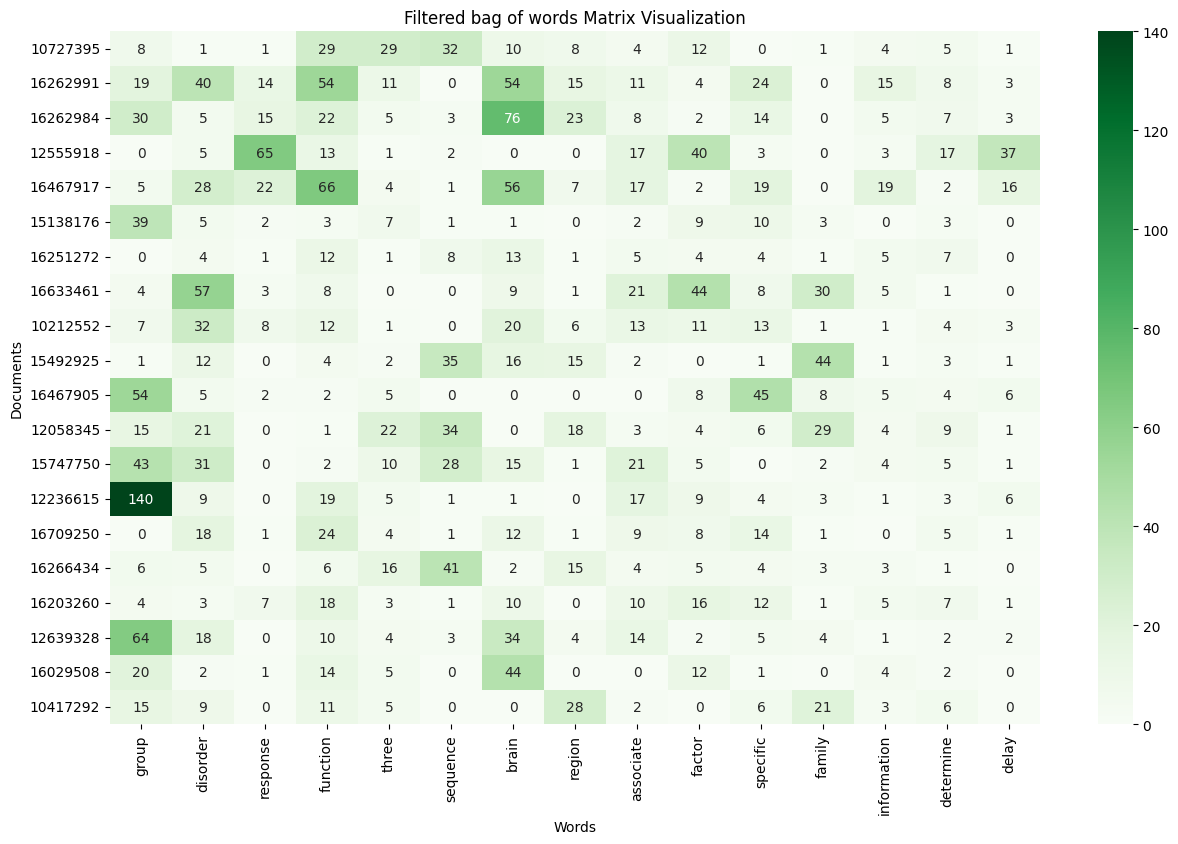

In [14]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered bag of words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

**Construct TF-IDF matrix from important words and n-grams**

The next script is designed to create a Term Frequency-Inverse Document Frequency (TF-IDF) matrix from a set of preprocessed documents and then refine this matrix by filtering out less relevant terms.

**Functionality**

1. *Creating the TF-IDF matrix*:<br>
   The script begins by generating a TF-IDF matrix using a list of preprocessed documents:
   - *TF-IDF matrix*: This matrix represents the importance of each word (or n-gram) across all documents in the corpus.
   - *`ngram_size`*: Specifies the size of word sequences to consider (e.g., unigrams, bigrams).
   - *`min_df`*: Filters out terms that appear in fewer than a specified number of documents, reducing noise in the analysis.

   This step is essential for transforming raw text data into a structured format that highlights important terms.

2. *Rearranging the TF-IDF matrix*:
   The script then refines the TF-IDF matrix by rearranging and filtering the terms:
   - *filtering*: The matrix is filtered based on criteria such as the importance of terms, ensuring that only the most relevant words remain.
   - *rearranging*: The matrix is reorganized according to a predefined order, based on the significance of terms or their relevance to specific documents.

   This refinement process is crucial for improving the quality of the analysis by focusing on the most impactful terms, which can lead to more accurate and insightful results.

**Use**

Users can apply this script as part of a larger text mining workflow where the TF-IDF matrix serves as an important step in structuring and analyzing the data. By filtering and refining the matrix, users can ensure that their analysis focuses on the most relevant and meaningful terms, leading to more meaningful insights. In the context of LBD, this script is an essential tool for turning raw text data into actionable insights.

In [15]:
# 1. Creating the TF-IDF matrix
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary with all n-grams: ', len(word_list))

# 2. Rearranging the TF-IDF matrix
#    Rearange (filter) the tfidf matrix according to the previously computed order from bow matrix.
tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary after removing infrequent n-grams and non MESH words: ', len(word_list))

Number of terms in initial vocabulary with all n-grams:  15238
Number of terms in preprocessed vocabulary after removing infrequent n-grams and non MESH words:  3991


**Compute margins for TF-IDF matrix**

This script is designed to analyze and manipulate Term Frequency-Inverse Document Frequency (TF-IDF) data for a corpus of documents. It computes various statistics related to the TF-IDF values for both words and documents, then filters the TF-IDF matrix to reorder it based on the most important words and documents.

**Functionality**

1. *Summing and Maximizing TF-IDF Values*:
   - `sum_count_each_word_in_all_documents`: Calculates the sum of TF-IDF scores for each word across all documents, providing insight into the overall importance of words in the entire corpus.
   - `max_tfidf_each_word_in_all_documents`: Finds the maximum TF-IDF score for each word, indicating the document where each word is most important.
   - `sum_count_all_words_in_each_document`: Computes the sum of TF-IDF scores for all words in each document, which can be used to determine the "weight" or importance of the document itself.
   - `max_tfidf_all_words_in_each_document`: Identifies the highest TF-IDF score for each document, which can help isolate which document contains particularly important terms.

2. *Output Statistics*:
   - The script uses Python's `itertools.islice` function to print a preview of the top 7 values from each TF-IDF statistic. This offers a quick way to inspect the data without overwhelming the output with large lists.

3. *Sorting and Filtering the TF-IDF Matrix*:
   - After calculating the TF-IDF statistics, the script computes an ordering for the rows (documents) and columns (words) based on the maximum TF-IDF values. This ensures that the most important terms and documents are given priority in subsequent analyses.
   - The `filter_matrix` function then reorders the original TF-IDF matrix based on these computed rankings, allowing for a focused view of the most significant content in the corpus.

**Practical applications**

- *Document analysis and classification*: By identifying the most important terms and documents in a corpus, this technique can assist in classifying documents into relevant categories.
- *Term and key concept extraction*: Researchers can use the sum and max TF-IDF scores to isolate critical keywords that may represent novel concepts or ideas in the context of Literature-Based Discovery.
- *Summarization and information retrieval*: By filtering out less important words and documents, this script can help narrow down a large corpus to the most relevant data, making retrieval tasks more efficient.

**Use**

This script is a practical tool for analyzing TF-IDF data in text mining applications. By summing and maximizing TF-IDF scores for words and documents, users can highlight the most significant elements of their corpus. The filtered matrix provides a more focused view of the most important terms, which is highly useful in fields like Literature-Based Discovery and NLP.


In [16]:
# 1. Summing and Maximizing TF-IDF Values
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

# 2. Output Statistics
print('Sum of TF-IDF for each word: ', dict(itertools.islice(sum_word_tfidf.items(), 7)))
print('Max of TF-IDF for each word: ', dict(itertools.islice(max_word_tfidf.items(), 7)))

print('Sum of TF-IDF for each document: ', dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print('Max of TF-IDF for each document: ', dict(itertools.islice(max_doc_tfidf.items(), 7)))

# 3. Sorting and Filtering the TF-IDF Matrix
#    Compute the order of rows (documents) and columns (words) in the tfidf matrix so that the most important words are in the top-left corner. 
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

#    Rearange (filter) the bow matrix according to the previously computed order.
filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

Sum of TF-IDF for each word:  {'2microglobulin': 0.02830402626821874, '4hydroxylase': 0.010821867599786088, '5ht1a': 0.06854368722857791, '5ht1a receptors': 0.05140776542143343, '5ht1b': 0.017135921807144478, '5ht2a': 0.029787415239302308, '5hydroxytryptophan': 0.034271843614288956}
Max of TF-IDF for each word:  {'2microglobulin': 0.02830402626821874, '4hydroxylase': 0.010821867599786088, '5ht1a': 0.06854368722857791, '5ht1a receptors': 0.05140776542143343, '5ht1b': 0.017135921807144478, '5ht2a': 0.029787415239302308, '5hydroxytryptophan': 0.034271843614288956}
Sum of TF-IDF for each document:  {'16911972': 5.522855396398783, '16835068': 10.450876900558278, '16816240': 5.693477794681375, '16770606': 8.61111316103656, '16722615': 8.327592437231832, '16709250': 11.16581350025962, '16703115': 5.54788796419041}
Max of TF-IDF for each document:  {'16911972': 0.5409945558443113, '16835068': 0.27884093127774645, '16816240': 0.389002887159674, '16770606': 0.36677623311935725, '16722615': 0.552

**Visualize a part of TF-IDF matrix**

Visualize the upper left part of the TF-IDF matrix. In the TF-IDF matrix, each row corresponds to a document and each column to a word (or n-gram). The values in the matrix represent the Term Frequency Inverse Document Frequency (abbreviated TF-IDF) of the word (term) in the corresponding document and document corpus. TF-IDF is a measure of how relevant a word in a document is in relation to a corpus: the measure increases proportionally to the number of occurrences of a word in the text, but is compensated for by the word frequency in the entire corpus.

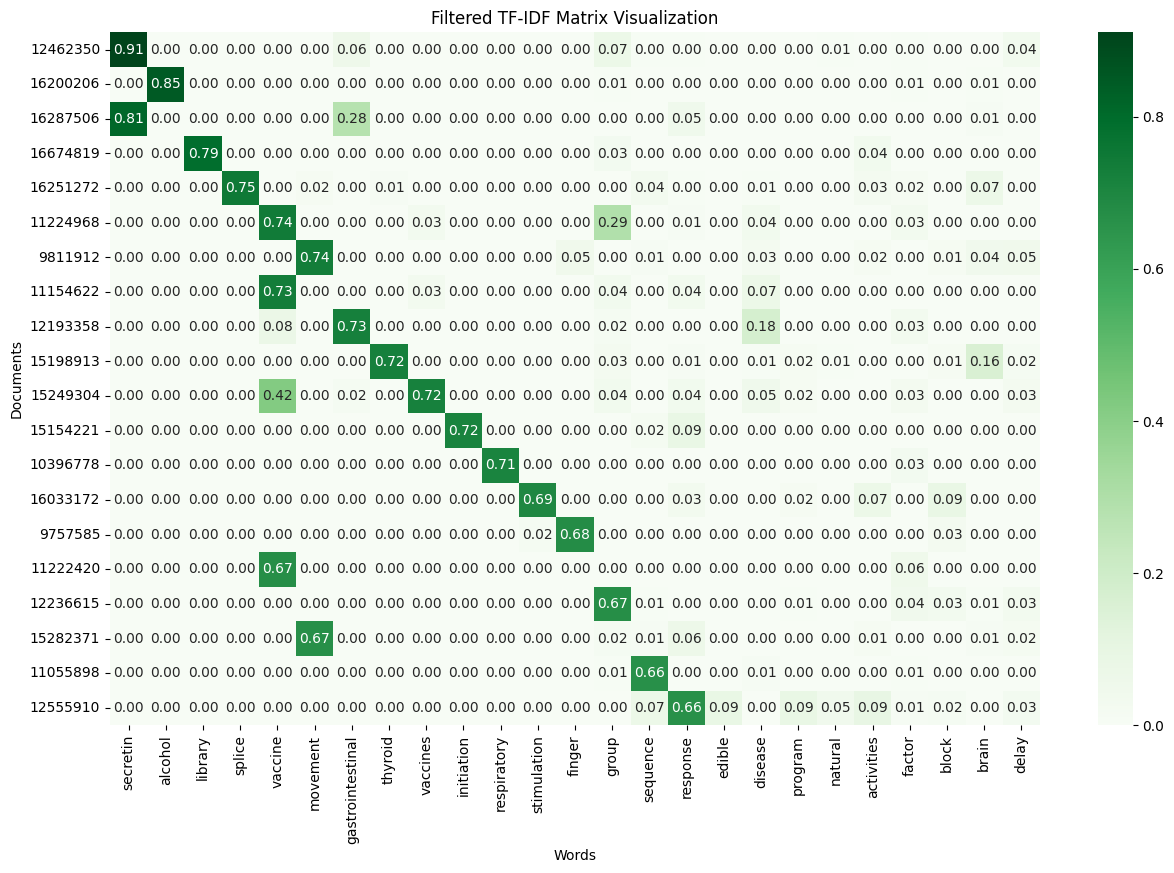

In [17]:
first_row = 0
last_row = 20
first_column = 0
last_column = 25
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TF-IDF', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

Create a list of domain names of all documents (from the dictionary containing the documents) and a list of unique domain names. Since all the documents are from the autism domain and there is no specific domain name for each document, we expect the only domain to be *NA*.

In [18]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('A list of all uniques domain names in all the documents: ', unique_domains_list)

Domain names for the first few documents:  ['NA', 'NA', 'NA', 'NA', 'NA', 'NA', 'NA']
A list of all uniques domain names in all the documents:  ['NA']


**Visualize the documents on a 2D similarity graph**

Visualize the documents in a 2D graph by reducing the dimensionality of the TF-IDF matrix with PCA. Visualizing TF-IDF data with PCA helps to understand complex, high-dimensional data by projecting it into a more interpretable form. In this analysis, the visualization is an add-on tool to understand the relationships between documents.

In [19]:
LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, domains_list, tfidf_matrix, transpose = False)

**Visualize the words from vocabulary on a 2D similarity graph**

Transpose the TF-IDF matrix to display similarity of the words (instead of the documents) in the graph.

In [20]:
domains_list = [LBD_02_data_preprocessing.strDomainDefault]*len(word_list)
LBD_06_visualization.visualize_tfidf_pca_interactive(word_list, domains_list, tfidf_matrix, transpose = True)

**Select and sort rare words**

The next script filters, sorts and analyzes *rare* words within a corpus based on their maximum TF-IDF values.

A word or n-gram is rare in the input documents if it only occurs in a relatively small portion of them. In this script, we assume that a term is rare if it only occurs in a single document. Note, however, that such a restriction is very sensitive to the addition of new elements to the input documents, since the rarity/frequency of a term in a text corpus can change by adding new texts to the existing input corpus. A rare term can become more frequent if the document added to the input file contains this term.

**Functionality**

1. *Filtering rare words*: The script first selects words that appear in only one document:
   - *filtering criteria*: Words appearing in only one document are considered rare and are selected for further analysis.

2. *Displaying and sorting words*: The script then prints and sorts these rare words by their maximum TF-IDF value:
   - *sorting*: Rare words are sorted in descending order by their TF-IDF scores, highlighting the most important terms.

3. *Analyzing the results*: The script calculates the mean TF-IDF value of the sorted rare words.

In [21]:
print("Dictionary of words, count and max(tfidf):")

# 1. Filtering rare words
max_word_tfidf_selected = {}
for word in max_word_tfidf.keys():
    if sum_count_docs_containing_word[word] <= 1:
        max_word_tfidf_selected[word] = max_word_tfidf[word]
         
# 2. displaying and sorting words
print('All the words in vocabulary: ', len(max_word_tfidf))
print('Selected rare words: ', len(max_word_tfidf_selected), ' ', dict(itertools.islice(max_word_tfidf_selected.items(), 30)))

max_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf_selected, True)
print('Sorted rare words: ', len(max_word_tfidf_selected_sorted), ' ', dict(itertools.islice(max_word_tfidf_selected_sorted.items(), 30)))

# 3. Analyzing the results
print('First and last sorted rare word: ', list(max_word_tfidf_selected_sorted.items())[0], ' ', list(max_word_tfidf_selected_sorted.items())[-1])
print('Mean value of max TF-IDF values: ', np.array(list(max_word_tfidf_selected_sorted.values())).mean())

Dictionary of words, count and max(tfidf):
All the words in vocabulary:  3991
Selected rare words:  495   {'2microglobulin': 0.02830402626821874, '4hydroxylase': 0.010821867599786088, '5ht1a': 0.06854368722857791, '5ht1a receptors': 0.05140776542143343, '5ht1b': 0.017135921807144478, '5ht2a': 0.029787415239302308, '5hydroxytryptophan': 0.034271843614288956, '5lipoxygenase': 0.03298331694574479, '5lipoxygenaseactivating': 0.03298331694574479, 'acceptor splice': 0.08394997767847819, 'accessory': 0.044742361213634466, 'acetylcholine': 0.09840346618166053, 'acetylcholinesterase': 0.06607751101593906, 'acidbinding': 0.014451052764701454, 'activate blood': 0.052843367755360776, 'activate neuronal': 0.07045782367381437, 'activate region': 0.08050961675949624, 'activate regions': 0.06440769340759699, 'activation general': 0.06440769340759699, 'activation plasma': 0.052843367755360776, 'activators': 0.03854297899401359, 'activity contain': 0.11125158466162871, 'activity essential': 0.0324656027

**Identify a few rare terms for further analysis**

In our experiment [1], the autism expert identified three rare terms *calcium channel*, *synaptophysin*, and *lactoylglutathione* that appeared in our dataset, prompting the autism expert to specifically search for their similarities and associations with autism.

In [22]:
rare_terms_list = list(max_word_tfidf_selected_sorted.keys())
rare_terms_list_length = len(rare_terms_list)

df = pd.DataFrame({'Rare term': rare_terms_list, 'max TF-IDF': list(max_word_tfidf_selected_sorted.values())})
# display the first 25 rare terms
df[0:25]

,Rare term,max TF-IDF
0,gliadin,0.513029
1,vancomycin,0.484120
2,finger sensory,0.367959
3,function transfer,0.357635
4,antimicrobial,0.322746
5,facilitative,0.297257
6,sensory finger,0.294367
7,interaction block,0.285611
8,vancomycin antimicrobial,0.242060
9,plasma virus,0.228988


In [23]:
# Optionally: for further inspection, save the list to a file
#with open('output\B_strings_list.txt', 'w') as file:
#    for string in rare_terms_list:
#        file.write(string + '\n')

**Expert selects a few promising rare terms**

The expert slects a few promising rare terms from the list. For the workflow from [1], let us check the presence and the position of the expert selected actual rare terms [1] in the candidate list: 

In [24]:
name = 'calcium channel'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

calcium channel: position in the list of rare terms 38 (495), max tfidf: 0.157


In [25]:
name = 'synaptophysin'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

synaptophysin: position in the list of rare terms 37 (495), max tfidf: 0.159


In [26]:

name = 'lactoylglutathione'
print(name, ': ', 'position in the list of rare terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

lactoylglutathione: position in the list of rare terms 377 (495), max tfidf: 0.031


The expert had searched the list of 495 rare term cadidates. In the last part of step Ra, the expert had identified three rare terms for further investigation:

* *calcium channel* (position 38/495),
* *synaptophysin* (position 37/495),
* and *lactoylglutathione* (position 377/495).

Note that the actual position of the selected rare terms in the list depends on the actual settings of the preprocessing parameters. For example, different settings for `min_word_length`,`keep_only_nouns` and `keep_only_mesh` may result in different candidates for rare terms. You can experiment with different settings of these parameters to observe their effects on the final selection.

# Step Jo

At this stage the three rare terms (*calcium channel*, *synaptophysin* and *lactoylglutathione*) were identified.

For each rare term, the documents were retrieved from PubMed with the function
```python
load_data_from_pubmed(search_str: str, min_date: str, max_date: str) -> List[str]:
```

from `LBD_01_data_acquisition.ipynb`. The texts were saved in local files for easier retrieval.

The actual parameters for downloading the documents were the following:

```python
load_data_from_pubmed('calcium channels[tiab]', '1950/01/01', '2005/12/31')
load_data_from_pubmed('synaptophysin[tiab]', '1950/01/01', '2005/12/31')
load_data_from_pubmed('lactoylglutathione[tiab]', '1950/01/01', '2005/12/31')
```
Let us now first load the documents from the files for the three rare terms.

In [27]:
fileName = 'input/f_calcium_channels.txt'
lines = LBD_01_data_acquisition.load_data_from_file(fileName)
[truncate_with_ellipsis(line, 110) for line in lines[:7]]

2024-09-27 12:51:11: INFO - Loaded 7994 lines from "input/f_calcium_channels.txt".


['18726361: !calcium_channels Mediation by calcium/calmodulin-dependent protein kinase II of suppression of G...',
 '18404509: !calcium_channels P2 nucleotide receptors on C2C12 satellite cells. In developing muscle cells en...',
 '17895214: !calcium_channels Mechanisms of action of neuroprotectants in stroke. During cerebral ischemia, t...',
 '17883219: !calcium_channels The effect of heterogeneously-distributed RyR channels on calcium dynamics in c...',
 '17846486: !calcium_channels Halothane modifies oxygen free radical activity on the voltage-sensitive calciu...',
 '17282562: !calcium_channels L-type calcium channels mediate synchronized spontaneous Ca We have detected sy...',
 '17271112: !calcium_channels Endothelium-independent vasorelaxant effect of puerarin on rat thoracic aorta. ...']

In [28]:
fileName = 'input/f_synaptophysin.txt'
lines2 = LBD_01_data_acquisition.load_data_from_file(fileName)
[truncate_with_ellipsis(line, 110) for line in lines2[:7]]

2024-09-27 12:51:12: INFO - Loaded 2921 lines from "input/f_synaptophysin.txt".


['17167646: !synaptophysin Skull base neurocytoma: case report and review of the literature of extraventricul...',
 '16735976: !synaptophysin [Mixed endocrine tumors]. Mixed endocrine tumors are tumors composed of at least t...',
 '16735972: !synaptophysin [Endocrine tumors: biology and physiopathology]. Endocrine tumors are defined as n...',
 '16648660: !synaptophysin A case of primary gastric small cell carcinoma with a rare pattern of lymph node m...',
 '21783668: !synaptophysin Neurotoxic effect of maneb in rats as studied by neurochemical and immunohistochem...',
 '16536278: !synaptophysin [Desmoplastic small round cell tumor: a clinicopathologic study of 15 cases]. To s...',
 '16520830: !synaptophysin Differential fate of multipotent and lineage-restricted neural precursors followin...']

In [29]:
fileName = 'input/f_lactoylglutathione.txt'
lines3 = LBD_01_data_acquisition.load_data_from_file(fileName)
[truncate_with_ellipsis(line, 110) for line in lines3[:7]]

2024-09-27 12:51:13: INFO - Loaded 751 lines from "input/f_lactoylglutathione.txt".


['16789882: !lactoylglutathione Novel experimental design for steady-state processes: a systematic Bayesian a...',
 '16713983: !lactoylglutathione Kinetic assay for measurement of enzyme concentration in situ. \n',
 '16511153: !lactoylglutathione Crystallization and preliminary X-ray analysis of Leishmania major glyoxalase...',
 '16384901: !lactoylglutathione Transgenic tobacco overexpressing glyoxalase pathway enzymes grow and set via...',
 '16352396: !lactoylglutathione Association analysis of the functional Ala111Glu polymorphism of the glyoxala...',
 '16333265: !lactoylglutathione Oxidative stress is the new stress. \n',
 '16305054: !lactoylglutathione Common polymorphisms in the glyoxalase-1 gene and their association with pro-...']

Combine all three input texts to a single list of documents.

In [30]:
lines.extend(lines2)
lines.extend(lines3)
len(lines)

11666

11.666 documents were collected from all three domains. The next step is to preprocess the list of input documents. A more detailed explanation can be found in the preprocessing in step *Ra*.

In [31]:
docs_dict = LBD_02_data_preprocessing.construct_dict_from_list(lines)

keep_list = []
remove_list = []
prep_docs_dict = LBD_02_data_preprocessing.preprocess_docs_dict(
    docs_dict, keep_list = keep_list, remove_list = remove_list, mesh_word_list = mesh_word_list, \
    cleaning = True, remove_stopwords = True, lemmatization = True, \
    min_word_length = 5, keep_only_nouns = False, keep_only_mesh = False, stemming = False, stem_type = None)

ids_list = LBD_02_data_preprocessing.extract_ids_list(prep_docs_dict)
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(prep_docs_dict)
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
prep_docs_list = LBD_02_data_preprocessing.extract_preprocessed_documents_list(prep_docs_dict)

2024-09-27 12:51:17: INFO - Text cleaning ...
2024-09-27 12:51:20: INFO - Removing stopwords ...
2024-09-27 12:51:21: INFO - Lemmatization ...
2024-09-27 12:51:27: INFO - Keeping only longer words (>= 5 characters)...
2024-09-27 12:51:27: INFO - Preprocessing finished.


Display the first 7 dictionary items. This time, the documents are **not truncated** since they contain only **the title and abstract**, and are, therefore, substantially shorter than the 214 complete articles about autism that were used in step *Ra* at the beginning of this notebook.

In [32]:
dict(itertools.islice(prep_docs_dict.items(), 7))

{'18726361': {'domain': 'calcium_channels',
  'document': 'Mediation by calcium/calmodulin-dependent protein kinase II of suppression of GABA(A) receptors by NMDA. Using nystatin-perforated whole-cell recording configuration, the modulatory effect of N-methyl-D-aspartate (NMDA) on gamma-aminobutyric acid (GABA)-activated whole-cell currents was investigated in neurons freshly dissociated from the rat sacral dorsal commissural nucleus (SDCN). The results showed that: (i) NMDA suppressed GABA-and muscimol (Mus)-activated currents (I(gaba) and I(Mus)), respectively in the Mg(2+)-free external solution containing 1 mumol/L glycine at a holding potential (V ( H )) of -40 mV in SDCN neurons. The selective NMDA receptor antagonist, D-2-amino-5-phosphonovaleric acid (APV, 100 gammamol/L), inhibited the NMDA-evoked currents and blocked the NMDA-induced suppression of I(gaba); (ii) when the neurons were incubated in a Ca(2+)-free bath or pre-loaded with a membrane-permeable Ca(2+) chelator, BAPT

**Creating and filtering a BoW representation from the preprocessed documents**

The script is designed to generate a Bag of Words (BoW) representation from a set of preprocessed documents and then refine the vocabulary by filtering out less relevant terms. This process focuses on the most meaningful terms to reduce noise in the data.

**Functionality**

1. *Generating the Bag of Words (BoW) representation*: The script starts by creating a BoW model:
   - *BoW model*: The BoW model is generated from the preprocessed documents, where each term (or n-gram) is counted across all documents.
   - *Parameters*:
     - *`ngram_size = 1`*: Specifies that only unigrams (single words) are considered.
     - *`min_df = 1`*: Includes all terms that appear in at least one document.

2. *Filtering the vocabulary*: The script then filters out terms based on specific criteria:
   - *Term frequency filtering*: Terms (or n-grams) that appear fewer than `min_count_ngram` times across all documents are removed.
   - *MeSH filtering*: If `keep_only_mesh_II` is set to `True`, only terms found in the MeSH (Medical Subject Headings) vocabulary are retained.

3. *Iterating and applying filters*: The script iterates through the word list, applying the filtering criteria.

4. *Preserving document order*: The script retains the original order of the documents.

5. *Generating the final filtered BoW matrix*: The script applies the filters to produce the final BoW matrix.

**Relevance**

Filtering the BoW matrix refines the vocabulary, removing less relevant or noisy terms and focusing on those that are more significant. This enhances the quality of subsequent analyses by reducing dimensionality and improving the relevance of the features used in tasks such as classification, clustering, or literature discovery.

**Practical applications**

- *Biomedical research and discovery*: Use this process to refine vocabulary in biomedical literature, ensuring that only relevant medical terms are analyzed.
- *Machine Learning and data preparation*: Improve the performance of ML models by using a filtered BoW matrix with fewer, more relevant features.

In [33]:
# 1. Generating the Bag of Words (BoW) representation
ngram_size = 1
min_df = 1

# BoW representation
word_list, bow_matrix = LBD_03_feature_extraction.create_bag_of_words(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary: ', len(word_list))

# 2. Filtering the vocabulary
#    remove nterms with frequency count less than min_count_ngram from vocabulary word_list and bow_matrix
min_count_ngram = 3
#    if keep_only_mesh_II is True, remove non-MeSH words from the vocabulary (note that this phase is after preprocessing text is completed)
keep_only_mesh_II = True

tmp_sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

tmp_sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

# 3. Iterating and applying filters
tmp_filter_columns = []
for i, word in enumerate(word_list):
    if not LBD_03_feature_extraction.word_is_nterm(word):
        if (not keep_only_mesh_II) or (word in mesh_word_list):
            tmp_filter_columns.append(i)
    else:
        if tmp_sum_count_word_in_docs[word] >= min_count_ngram:
            check_ngram = word.split()
            passed = True
            for check_word in check_ngram:
                if keep_only_mesh_II:
                    if check_word not in mesh_word_list:
                        passed = False
            if check_ngram[0] == check_ngram[1]:
                passed = False
            if passed:
                tmp_filter_columns.append(i)

# 4. Preserving document order
tmp_filter_rows = []
for i, id in enumerate(ids_list):
    tmp_filter_rows.append(i)

# 5. Generating the final filtered BoW matrix
tmp_filtered_word_list, tmp_filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, bow_matrix, tmp_filter_rows, tmp_filter_columns)

word_list = tmp_filtered_word_list
bow_matrix = tmp_filtered_bow_matrix
print('Number of terms in preprocessed vocabulary: ', len(word_list))

Number of terms in initial vocabulary:  42875
Number of terms in preprocessed vocabulary:  1624


**Aggregate the BoW matrix by domain**

This script aggregates a Bag of Words (BoW) matrix by combining rows corresponding to documents from the same domain into a single row. This process results in a new matrix, `domains_bow_matrix`, where each row represents the aggregated word counts for a unique domain. This aggregation is useful when analyzing the distribution of terms across different domains or sources.

**Functionality**

1. *Initialization of the domains BoW matrix*: The script begins by creating an empty matrix to store the aggregated results.
   - *Empty matrix*: The matrix is initialized with zero rows and a number of columns equal to the original BoW matrix, ready to store aggregated word counts.

2. *Iterating over unique domains*: The script then iterates over each unique domain in the dataset.
   - *Domain filtering*: For each domain, the script identifies the indices of documents associated with that domain using the `domains_list`.

3. *Aggregating word counts*: For each domain, the script aggregates the word counts from all associated documents.
   - *Summation*: The script sums the word counts across all rows (documents) associated with the current domain, producing a single vector of aggregated counts.

4. *Appending to the domains BoW matrix*: The aggregated counts for each domain are appended as a new row to the `domains_bow_matrix`.
   - *Matrix update*: The new row is vertically stacked onto the `domains_bow_matrix`, building up the final matrix where each row corresponds to a unique domain.

5. *Displaying the result*: Finally, the script prints the completed `domains_bow_matrix`.
   - *Output*: The matrix shows the aggregated word counts for each domain, which can be used for further analysis.

**Relevance**

Aggregating the BoW matrix by domain allows researchers to analyze the overall term frequency distributions across different sources or domains. This can reveal how specific terms or topics are emphasized in different domains, which is crucial for understanding the influence of sources in a given dataset.

**Practical applications**

- *Machine Learning and data preparation*: Assess the focus or bias of different domains in a corpus, such as comparing how different journals or websites discuss a topic. For businesses, analyze how competitors or industry leaders emphasize different topics across their content.
- *Topic modeling and clustering*: Use the aggregated data to perform domain-level topic modeling, identifying themes specific to certain sources.

**Use**

To use this script, ensure you have a BoW matrix (`bow_matrix`) and a list of domain names (`domains_list`). The script will generate a new matrix, `domains_bow_matrix`, where each row corresponds to the aggregated word counts for a unique domain. This matrix can then be used for domain-level analysis or further text mining tasks.

In [34]:
# Generate domains_bow_matrix from bow_matrix using domain_names list to add bow_matrix rows for each unique domain name into a single row

# 1. Initialization of the domains BoW matrix
domains_bow_matrix = np.empty((0, bow_matrix.shape[1]))

# 2. Iterating over unique domains
for i, domain_name in enumerate(unique_domains_list):
    domain_docs_indices = [i for i, label in enumerate(domains_list) if label == domain_name]
    # 3. Aggregating word counts
    tmp = (bow_matrix[domain_docs_indices,:]).sum(axis=0)
    # 4. Appending to the domains BoW matrix
    domains_bow_matrix = np.vstack((domains_bow_matrix, tmp))

# 5. Displaying the result
print('Domain names (lines): ', unique_domains_list)
print(domains_bow_matrix)

Domain names (lines):  ['calcium_channels', 'synaptophysin', 'lactoylglutathione']
[[104.   5.   0. ...   3.   3.   0.]
 [ 10.   0.   3. ...   0.   0.   1.]
 [  0.   0.   0. ...   0.   1.   0.]]


The function `cell_value_in_bow_matrix` is designed to retrieve the frequency of a specific word from a Bag of Words (BoW) matrix for a specified domain. 

**Functionality**

1. *Identifying the row for the domain*: The function starts by finding the row index in the BoW matrix that corresponds to the given domain name.
   - *Domain lookup*: The function searches the `unique_domains_list` to find the index of the specified `domain_name`. This index corresponds to the row in the BoW matrix where the word frequencies for that domain are stored.

2. *Identifying the column for the word*: The function then determines the column index for the specified word.
   - *Word lookup*: The function searches the `word_list` to find the index of the specified `word`. This index corresponds to the column in the BoW matrix where the frequency of that word is stored.

3. *Retrieving the word's frequency*: Finally, the function returns the frequency of the specified word for the given domain by accessing the appropriate cell in the BoW matrix.
   - *Cell value*: The function returns the value at the intersection of the identified row and column, which represents the frequency of the word in the documents associated with the domain.

**Relevance**

This function provides a quick and straightforward way to access specific information from a BoW matrix. This is particularly useful when analyzing how specific topics or keywords are represented in various sources or domains.

In [35]:
def cell_value_in_bow_matrix(bow_matrix: any, domain_name: str, word: str):
    """
    This function returns the value of a word in a BoW matrix for a given domain.
    """
    # 1. Identifying the row for the domain
    line_idx = unique_domains_list.index(domain_name)
    # 2. Identifying the column for the word
    column_idx = word_list.index(word)
    # 3. Retrieving the word's frequency
    return(bow_matrix[line_idx, column_idx])

**Analyzing and filtering a BoW matrix**

This script is designed to analyze the distribution of words in a Bag of Words (BoW) matrix, calculate various word and document frequency metrics, and then filter the BoW matrix based on these metrics. This process is essential in Text Mining and Literature-Based Discovery (LBD) to ensure that only the most relevant terms and documents are retained for further analysis.

**Functionality**

1. *Calculating frequency metrics*:
   The script starts by calculating key metrics that describe how words and documents are distributed in the BoW matrix.
   - *Document frequency (`sum_count_docs_containing_word`)*: Counts how many documents contain each word.
   - *Word frequency (`sum_count_word_in_docs`)*: Totals the occurrences of each word across all documents.
   - *Document word count (`sum_count_words_in_doc`)*: Sums the number of words in each document.

2. *Displaying frequency metrics*: The script then prints a sample of these metrics to provide insight into the data distribution.
   - *Sample Output*: The script uses `itertools.islice` to display the first few entries of each metric, helping users understand the frequency distribution of terms and documents.

3. *Filtering the BoW matrix*: The script proceeds to filter the BoW matrix based on the calculated metrics.
   - *Column Filtering*: Filters the words (columns) based on their overall frequency across documents, prioritizing the most frequent terms.
   - *Row Filtering*: Filters the documents (rows) based on their total word count, prioritizing documents with the most content.

4. *Applying the Filters*: The script applies the filters to the BoW matrix, generating a refined matrix.
   - *Filtered Matrix*: The resulting `filtered_bow_matrix` contains only the most relevant words and documents based on the filtering criteria.

5. *Displaying filtered results*: Finally, the script prints a sample of the filtered document IDs.

**Relevance**

This script refines the BoW matrix by focusing on the most significant words and documents, reducing noise and improving the quality of the data for subsequent analysis. This is crucial for tasks like text classification, clustering, or topic modeling, where low-frequency terms can obscure the results.

**Practical applications**

- *Document analysis and classification*: Improve model performance by training on a refined set of features.
- *Topic modeling and clustering*: Generate more accurate topics by focusing on high-frequency terms. Enhance clustering results by considering documents with the most content.

**Use**

To use this script, provide a BoW matrix (`bow_matrix`), along with lists of words (`word_list`) and document IDs (`ids_list`). The script will calculate frequency metrics, filter the matrix, and return a refined version of the BoW matrix that can be used for further analysis or modeling tasks. This process is vital for ensuring that your analysis is based on the most relevant and informative data.

In [36]:
# 1. Calculating frequency metrics
sum_count_docs_containing_word = LBD_03_feature_extraction.sum_count_documents_containing_each_word(word_list, bow_matrix)

sum_count_word_in_docs = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, bow_matrix)

sum_count_words_in_doc = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, bow_matrix)

# 2. Displaying frequency metrics
print(dict(itertools.islice(sum_count_docs_containing_word.items(), 7)))
print(dict(itertools.islice(sum_count_word_in_docs.items(), 7)))
print(dict(itertools.islice(sum_count_words_in_doc.items(), 7)))

# 3. Filtering the BoW matrix
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_word_in_docs, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(sum_count_words_in_doc, reverse=True), ids_list) 

# 4. Applying the Filters
filtered_ids_list, filtered_word_list, filtered_bow_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, bow_matrix, filter_rows, filter_columns)

# 5. Displaying filtered results
print(filtered_ids_list[:7])

{'145trisphosphate': 85, '1alpha': 4, '1antichymotrypsin': 3, '1antitrypsin': 4, '1beta': 4, '1phosphate': 2, '21hydroxylase': 8}
{'145trisphosphate': 114, '1alpha': 5, '1antichymotrypsin': 3, '1antitrypsin': 4, '1beta': 4, '1phosphate': 3, '21hydroxylase': 12}
{'18726361': 24, '18404509': 39, '17895214': 70, '17883219': 40, '17846486': 10, '17282562': 3, '17271112': 19}
['9732408', '15826932', '8567934', '11226046', '11726244', '8646567', '9483533']


Display a part of the BoW matrix.

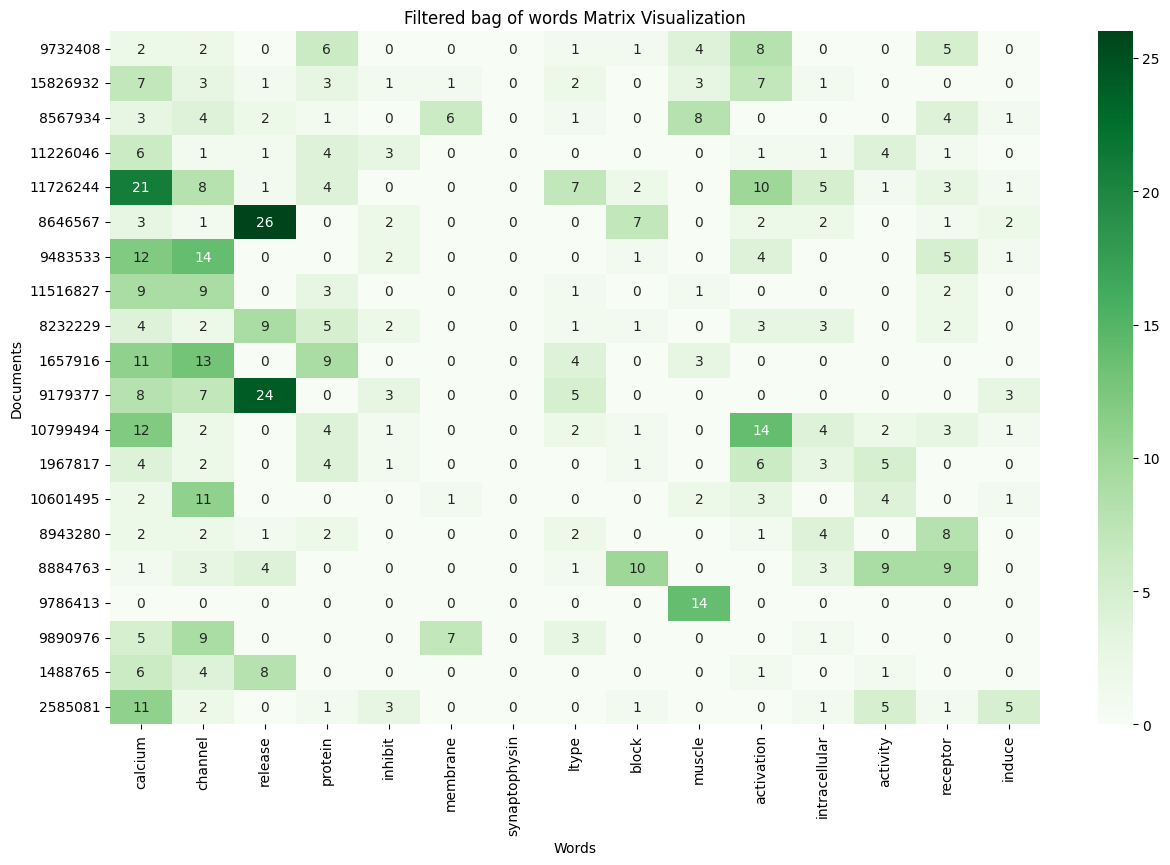

In [37]:
first_row = 0
last_row = 20
first_column = 0
last_column = 15
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered bag of words', \
                                           filtered_bow_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], \
                                           filtered_word_list[first_column:last_column], as_int = True)

**Creating and refining a TF-IDF matrix**

This script generates a Term Frequency-Inverse Document Frequency (TF-IDF) matrix from a set of preprocessed documents and then refines the matrix by filtering out less relevant terms. 

**Functionality**

1. *Generating the TF-IDF matrix*: The script begins by creating a TF-IDF matrix from the preprocessed documents.
   - *TF-IDF matrix*: This matrix represents the importance of each term (or n-gram) in the corpus based on its frequency and how unique it is across documents.
   - *Parameters*:
     - *`ngram_size`*: Specifies the size of the n-grams to be considered.
     - *`min_df`*: Filters out terms that appear in fewer than a certain number of documents.

2. *Filtering the TF-IDF matrix*: After creating the TF-IDF matrix, the script filters the matrix to remove less relevant terms.
   - *Filtering Criteria*: The filtering process is based on predefined rows (`tmp_filter_rows`) and columns (`tmp_filter_columns`), which could be determined by factors such as term frequency or document relevance.

3. *Updating the matrix*: The script updates the TF-IDF matrix and word list to reflect the filtered data.
   - *Result*: The filtered `tfidf_matrix` and corresponding `word_list` contain only the most relevant terms, making subsequent analysis more focused and effective.

**Relevance**

TF-IDF is a critical technique for identifying and emphasizing important terms in a text corpus. By filtering the matrix to retain only the most relevant terms, the script improves the quality of the data, which is crucial for effective text analysis, classification, and clustering.

**Use**

To use this script, input a list of preprocessed documents (`prep_docs_list`) and define the parameters for n-grams and minimum document frequency. The script will generate a TF-IDF matrix, filter it based on relevance, and return a refined version that is ready for further analysis or modeling tasks. This process is essential for extracting meaningful insights from large text datasets.

In [38]:
# 1. Generating the TF-IDF matrix
word_list, tfidf_matrix = LBD_03_feature_extraction.create_tfidf(prep_docs_list, ngram_size, min_df)
print('Number of terms in initial vocabulary: ',  len(word_list))

# 2. Filtering the TF-IDF matrix
tmp_filtered_word_list, tmp_filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix_columns(
    word_list, tfidf_matrix, tmp_filter_rows, tmp_filter_columns)

# 3. Updating the matrix
word_list = tmp_filtered_word_list
tfidf_matrix = tmp_filtered_tfidf_matrix
print('Number of terms in preprocessed vocabulary: ', len(word_list))

Number of terms in initial vocabulary:  42875
Number of terms in preprocessed vocabulary:  1624


**Analyzing and filtering a TF-IDF matrix**

The next script performs several key tasks related to analyzing and manipulating Term Frequency-Inverse Document Frequency (TF-IDF) data for a corpus of documents. It computes the sum and maximum of TF-IDF values for words and documents, and then filters and reorders the TF-IDF matrix to prioritize the most important words and documents.

**Functionality**

1. *TF-IDF Statistics for words and documents*: The script first computes two key metrics for both words and documents using functions from the `LBD_03_feature_extraction` module.
    - *Sum of TF-IDF for each word across all documents*: This gives an idea of the overall importance of each word in the entire corpus.
    - *Maximum TF-IDF for each word*: Indicates in which document each word has its highest impact.
    - *Sum of TF-IDF for all words in each document*: This shows the overall significance of each document in terms of word importance.
    - *Maximum TF-IDF for each document*: Reveals the highest word contribution to each document.
   
2. *Previewing TF-IDF Statistics*: The script then prints the first 7 entries for each computed statistic, using `itertools.islice` to create a preview. This allows users to quickly check the results without printing the entire dataset.

3. *Sorting and filtering*: After computing the TF-IDF statistics, the script determines which words and documents are most important based on their maximum TF-IDF values. It does this by:
    - Sorting the words based on their maximum TF-IDF scores in descending order.
    - Sorting the documents similarly based on their maximum word scores.

4. *Reordering the TF-IDF matrix*: The final step reorders the TF-IDF matrix by applying the sorted indices of words (columns) and documents (rows) to focus on the most important elements. This filtered matrix highlights the significant content of the corpus, making it easier to analyze or visualize.

**Practical applications**

- *Biomedical research and discovery*: Researchers can use this method to focus on the most important concepts in a large corpus of scientific papers or patents, helping to identify novel connections between seemingly unrelated topics.
- *Summarization and information retrieval*: By focusing on high TF-IDF words, users can create concise summaries of documents that contain the most relevant information.
- *Document analysis and classification*: TF-IDF data can serve as a foundation for machine learning models to classify documents based on their most important terms.
- *Term and key concept extraction*: The sum and max TF-IDF values provide insight into the key terms within a corpus, which can be used for tasks like topic modeling, keyword extraction, and search engine optimization.

In [39]:
# 1. TF-IDF Statistics for words and documents
sum_word_tfidf = LBD_03_feature_extraction.sum_count_each_word_in_all_documents(word_list, tfidf_matrix)
max_word_tfidf = LBD_03_feature_extraction.max_tfidf_each_word_in_all_documents(word_list, tfidf_matrix)

sum_doc_tfidf = LBD_03_feature_extraction.sum_count_all_words_in_each_document(ids_list, tfidf_matrix)
max_doc_tfidf = LBD_03_feature_extraction.max_tfidf_all_words_in_each_document(ids_list, tfidf_matrix)

# 2. Previewing TF-IDF Statistics
print(dict(itertools.islice(sum_word_tfidf.items(), 7)))
print(dict(itertools.islice(max_word_tfidf.items(), 7)))

print(dict(itertools.islice(sum_doc_tfidf.items(), 7)))
print(dict(itertools.islice(max_doc_tfidf.items(), 7)))

# 3. Sorting and filtering
filter_columns = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf, reverse=True), word_list)
filter_rows = LBD_02_data_preprocessing.get_index_list_of_dict1_keys(
    LBD_02_data_preprocessing.sort_dict_by_value(max_doc_tfidf, reverse=True), ids_list) 

# 4. Reordering the TF-IDF matrix
filtered_ids_list, filtered_word_list, filtered_tfidf_matrix = LBD_03_feature_extraction.filter_matrix(
    ids_list, word_list, tfidf_matrix, filter_rows, filter_columns)

{'145trisphosphate': 9.17216109964925, '1alpha': 0.4148907553872049, '1antichymotrypsin': 0.4274134145235772, '1antitrypsin': 0.5268103481401317, '1beta': 0.4144670180129725, '1phosphate': 0.31957598240261625, '21hydroxylase': 2.385477423879147}
{'145trisphosphate': 0.4785154967647917, '1alpha': 0.1420051679020841, '1antichymotrypsin': 0.19536261495483423, '1antitrypsin': 0.1905067289393233, '1beta': 0.1290979947976396, '1phosphate': 0.2291353138866748, '21hydroxylase': 0.5478389397532072}
{'18726361': 1.1356318019927265, '18404509': 1.7817305543900748, '17895214': 2.3819184124709563, '17883219': 1.5857302620856233, '17846486': 0.5032740685318721, '17282562': 0.3105694904869173, '17271112': 0.6902093849699373}
{'18726361': 0.18263436298014132, '18404509': 0.3449562646761432, '17895214': 0.24737071711909994, '17883219': 0.20998593070390167, '17846486': 0.18881893054830848, '17282562': 0.1547924300584975, '17271112': 0.1464958019546046}


Display a part of the TF-IDF matrix.

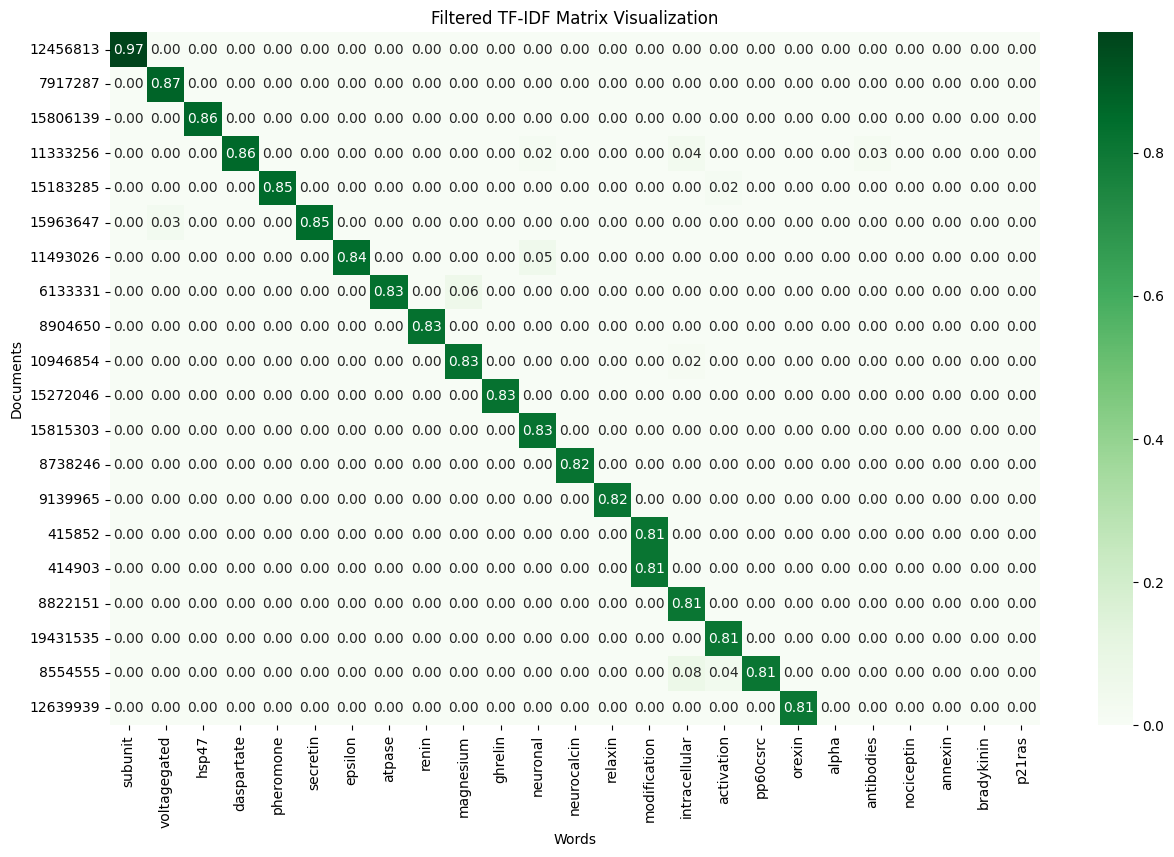

In [40]:
first_row = 0
last_row = 20
first_column = 0
last_column = 25
LBD_06_visualization.plot_bow_tfidf_matrix('Filtered TF-IDF', filtered_tfidf_matrix[first_row:last_row,first_column:last_column], \
                                           filtered_ids_list[first_row:last_row], filtered_word_list[first_column:last_column], as_int = False)

Print domain names and the number of the correponding documents.

In [41]:
domains_list = LBD_02_data_preprocessing.extract_domain_names_list(docs_dict)
print('Domain names for the first few documents: ', domains_list[:7])
unique_domains_list = LBD_02_data_preprocessing.extract_unique_domain_names_list(prep_docs_dict)
print('Unique domain names: ', unique_domains_list)
print('Number of documents in each unique domain: ', )
for unique_domain in unique_domains_list:
    print('   ', unique_domain, ': ', domains_list.count(unique_domain), sep='')


Domain names for the first few documents:  ['calcium_channels', 'calcium_channels', 'calcium_channels', 'calcium_channels', 'calcium_channels', 'calcium_channels', 'calcium_channels']
Unique domain names:  ['calcium_channels', 'synaptophysin', 'lactoylglutathione']
Number of documents in each unique domain: 
   calcium_channels: 7986
   synaptophysin: 2921
   lactoylglutathione: 751


**Visualize the documents on a 2D similarity graph**

In [42]:
LBD_06_visualization.visualize_tfidf_pca_interactive(ids_list, domains_list, tfidf_matrix, transpose = False)

**Visualize the words on a 2D similarity graph**

In [43]:
domains_list = ['default']*len(word_list)
LBD_06_visualization.visualize_tfidf_pca_interactive(word_list, domains_list, tfidf_matrix, transpose = True)

**Selecting and sorting joint words based on TF-IDF scores**

The next script is designed to filter and rank words based on their Term Frequency-Inverse Document Frequency (TF-IDF) scores, selecting only those words that appear in at least 10 documents and are present in all specified domains. The selected words are then sorted by their maximum TF-IDF values, and some statistics are computed, such as the mean TF-IDF score.

**Functionality**

1. *Filtering words based on document frequency and domain presence*: The script first creates an empty dictionary `max_word_tfidf_selected` to store words that meet two criteria:
   - The word must appear in at least 10 documents (`sum_count_docs_containing_word[word] >= 10`).
   - The word must appear in all specified domains (`unique_domains_list`).
   
2. *Display basic information*: The script prints the total number of words in the vocabulary and the number of selected common words that pass the filtering criteria.

3. *Sorting the selected words by TF-IDF score*: Once the common words are selected, the script sorts them in descending order of their maximum TF-IDF scores using the `sort_dict_by_value` function from the `LBD_02_data_preprocessing` module. This provides a ranked list of the most important common words.

4. *Additional output and statistics*: The script prints the first and last word in the sorted list, providing an easy reference for the most and least significant words based on TF-IDF. Finally, it computes and prints the mean value of the maximum TF-IDF scores for the selected words, offering a statistical summary of the importance of the chosen terms.

**Practical applications**

- *Cross-domain term and key concept extraction*: By selecting words that are significant across all domains, this script can help identify key concepts that are common and important across different fields of study. This is particularly useful in interdisciplinary research and Literature-Based Discovery.
- *Summarization and information retrieval*: The filtering and sorting process helps extract the most important terms, which can be useful in summarizing a corpus by focusing on the most relevant and widely applicable concepts.
- *Document analysis and classification*: By identifying the most important common words, this approach can assist in building more effective topic models or classification systems that are suited to specific domains or knowledge areas.

In [44]:
print("Dictionary of words, count and max(tfidf):")

# 1. Filtering words based on document frequency and domain presence
max_word_tfidf_selected = {}
for word in max_word_tfidf.keys():
    if sum_count_docs_containing_word[word] >= 10:
        passed = True
        for domain_name in unique_domains_list:
            if cell_value_in_bow_matrix(domains_bow_matrix, domain_name, word) <= 0:
                passed = False
        if passed:
            max_word_tfidf_selected[word] = max_word_tfidf[word]

# 2. Display basic information        
print('All the words in vocabulary: ', len(max_word_tfidf))
print('Selected common words: ', len(max_word_tfidf_selected), ' ', dict(itertools.islice(max_word_tfidf_selected.items(), 30)))

# 3. Sorting the selected words by TF-IDF score
max_word_tfidf_selected_sorted = LBD_02_data_preprocessing.sort_dict_by_value(max_word_tfidf_selected, True)

# 4. Additional output and statistics
print('Sorted joint words: ', len(max_word_tfidf_selected_sorted), ' ', dict(itertools.islice(max_word_tfidf_selected_sorted.items(), 30)))
print('First and last sorted joint word: ', list(max_word_tfidf_selected_sorted.items())[0], ' ', list(max_word_tfidf_selected_sorted.items())[-1])
print('Mean value of max tfidf values: ', np.array(list(max_word_tfidf_selected_sorted.values())).mean())

Dictionary of words, count and max(tfidf):
All the words in vocabulary:  1624
Selected common words:  428   {'abnormal': 0.32940834822454046, 'accessory': 0.5230251219466555, 'acetate': 0.36881506605989645, 'acidic': 0.30035997108318374, 'acids': 0.5365463008382456, 'actin': 0.45721048145225107, 'activate': 0.3304728776508911, 'activation': 0.8100153752317802, 'activator': 0.2745245259139501, 'activities': 0.32152794392621714, 'activity': 0.4584039068518901, 'acute': 0.37864275362186256, 'adenine': 0.3303918311846703, 'adenosine': 0.6613637197911795, 'adenylate': 0.49619141171378534, 'adhesion': 0.346802382662499, 'adrenergic': 0.40024597455204997, 'advance': 0.43822322012500703, 'aggregate': 0.5495700072780855, 'alanine': 0.38540663500674954, 'albumin': 0.35645581026463075, 'alcohol': 0.652349292157844, 'aldehyde': 0.4570622489178107, 'alkaline': 0.6930367731859913, 'alpha': 0.8075882653346256, 'alternative': 0.46018501349662805, 'amide': 0.25452759653374657, 'amine': 0.26705650210459

In [45]:
joint_terms_list = list(max_word_tfidf_selected_sorted.keys())
joint_terms_list_length = len(joint_terms_list)

df = pd.DataFrame({'Joint term': joint_terms_list, 'max TF-IDF': list(max_word_tfidf_selected_sorted.values())})
df[0:25]

,Joint term,max TF-IDF
0,subunit,0.968369
1,magnesium,0.830567
2,neuronal,0.827465
3,modification,0.813919
4,intracellular,0.810697
5,activation,0.810015
6,alpha,0.807588
7,antibodies,0.805984
8,annexin,0.794119
9,liver,0.782100


In [46]:
name = 'calcineurin'
print(name, ': ', 'position in the ordered list of joint terms ', list(max_word_tfidf_selected_sorted.keys()).index(name), ' (', len(max_word_tfidf_selected_sorted), \
      '), max tfidf: ', format(max_word_tfidf_selected_sorted[name], '.3f'), sep='')

calcineurin: position in the ordered list of joint terms 17 (428), max tfidf: 0.734


In the last part of the step Jo we have identified a joint term for further exploration: *calcineurin*.
So, the Literature *C* is *autism* and the Literature *A* is *calcineurin*. In step Link the task is to search for linking b-terms that connect the two domains *C* and *A*.

# Step Link

Step Link implements closed discovery principle between two domains, in our case `autism` and `calcineurin`. It is implemented in `LBD_mini_CrossBee.ipynb` notebook.